# Prediction Training

In [1]:
import pandas as pd
import datetime as td
import  numpy as np
import datetime 
import datetime as dt
import numpy as np
import sys


In [2]:
forecastRaw = pd.read_csv('forecastData/PPForecast.csv')
forecast=forecastRaw.drop(['windGust'],1)
forecast= forecast.dropna()
forecast.columns=['date','dub_temp','dub_wddir','dub_wdsp','dub_hum','dub_press']
forecast=forecast._convert(numeric=True)
rawTemp=forecast['dub_temp']

/tmp/ipykernel_478551/2035226236.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  forecast=forecastRaw.drop(['windGust'],1)


In [3]:
forecast

,date,dub_temp,dub_wddir,dub_wdsp,dub_hum,dub_press
0,2022-07-16T17:00:00Z,24.3,221.8,3.7,52.4,1024.2
2,2022-07-16T18:00:00Z,24.0,218.0,3.1,50.7,1023.9
4,2022-07-16T19:00:00Z,22.8,206.8,3.5,51.5,1023.9
6,2022-07-16T20:00:00Z,21.7,162.3,2.4,51.3,1023.1
8,2022-07-16T21:00:00Z,21.0,146.8,1.2,53.2,1023.7
...,...,...,...,...,...,...
206,2022-07-25T00:00:00Z,16.1,239.3,5.7,86.0,1002.8
208,2022-07-25T06:00:00Z,14.0,267.2,8.5,84.2,1005.9
210,2022-07-25T12:00:00Z,16.6,282.9,8.2,63.8,1011.1
212,2022-07-25T18:00:00Z,17.2,280.1,5.5,58.2,1012.4


In [4]:
forecast = pd.read_csv('forecastData/PPForecast.csv')
forecast=forecast.drop(['windGust'],1)
forecast= forecast.dropna()
forecast.columns=['date','dub_temp','dub_wddir','dub_wdsp','dub_hum','dub_press']
forecast=forecast._convert(numeric=True)


#Just taking the columns used in prediction
finalCols= ['date','dub_temp','dub_wddir','dub_wdsp']
forecast = forecast[finalCols]

train_mean = np.loadtxt("./models/train_meanSave.csv",delimiter=',')
train_std = np.loadtxt("./models/train_stdSave.csv",delimiter=',')



forecast['date']=pd.to_datetime(forecast.date)

dateCol=forecast['date']
forecast=forecast.drop('date',1)


forecast = (forecast - train_mean) / train_std

forecast['date']=dateCol
forecast["dayInMonth"] =forecast['date'].dt.day

## Need to add a cos function for day of week
import math as ma
forecast['hour']=forecast['date'].dt.hour
forecast['dayOfWeek']=forecast['date'].dt.day_of_week
forecast['dayOfYear']=forecast['date'].dt.day_of_year

forecast["sin_hour"]=np.sin(forecast["hour"]/24*2*ma.pi)
forecast["sin_day"]=np.sin(forecast["dayOfYear"]/365*(2*ma.pi))


forecast["cos_hour"]=np.sin(forecast["hour"]/24*2*ma.pi)
forecast["cos_day"]=np.sin(forecast["dayOfYear"]/365*(2*ma.pi))


/tmp/ipykernel_478551/1133376207.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  forecast=forecast.drop(['windGust'],1)
/tmp/ipykernel_478551/1133376207.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  forecast=forecast.drop('date',1)


In [5]:
usedCols=['sin_day','sin_hour','cos_day','cos_hour','dub_wddir','dub_wdsp','dub_temp']

### Using tensorflow make dataset

In [6]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

In [7]:
@property
def val(self):
  return self.make_dataset(self.val_df3)

### Importing the model

In [8]:
import tensorflow as tf
conv_model = tf.keras.models.load_model('models/conv_model')

# Check its architecture
conv_model.summary()

2022-07-17 09:20:33.647372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-17 09:20:33.647435: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-17 09:20:36.466877: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-17 09:20:36.466955: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-17 09:20:36.466987: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x20217366): /proc/driver/nvidia/version does not exist


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 32)          480       
                                                                 
 dense_9 (Dense)             (None, None, 32)          1056      
                                                                 
 dense_10 (Dense)            (None, None, 1)           33        
                                                                 
Total params: 1,569
Trainable params: 1,569
Non-trainable params: 0
_________________________________________________________________


In [9]:
forecastData= forecast.drop(['date','dayInMonth','hour','dayOfWeek','dayOfYear'],1)
forecastData= forecastData[['sin_day', 'sin_hour', 'cos_day', 'cos_hour', 'dub_wddir', 'dub_wdsp','dub_temp']]

/tmp/ipykernel_478551/3350166663.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  forecastData= forecast.drop(['date','dayInMonth','hour','dayOfWeek','dayOfYear'],1)


In [10]:
def make_dataset( data):
    data = np.array(data, dtype=np.float32)
    print("Data is  given by",data.shape)
    inputData=data
    print("Input data is given by", inputData.shape)

    ds = tf.keras.utils.timeseries_dataset_from_array(
        inputData,
        targets=None,
        sequence_length=3,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)
    print("ds is given by ",ds)
    #ds = ds.map(self.split_window)

    return ds

In [11]:
forecastDs=make_dataset(forecastData)

Data is  given by (108, 7)
Input data is given by (108, 7)
ds is given by  <BatchDataset element_spec=TensorSpec(shape=(None, None, 7), dtype=tf.float32, name=None)>


In [12]:
forecastArr=conv_model.predict(forecastDs)

4/4 [==============================] - 0s 7ms/step


In [13]:
len(forecastArr.ravel())

212

In [14]:
forecastPred=forecastArr[:,1]

#forecastArr.ravel()

In [15]:
'''
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
plt.plot(X_valid['date2'][-7*24:],y_pred[-7*24:],color = 'blue')
plt.plot(X_valid['date2'][-7*24:],y_valid[-7*24:],color = 'red')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
'''

"\nimport matplotlib.pyplot as plt \nfrom matplotlib.pyplot import figure\nplt.plot(X_valid['date2'][-7*24:],y_pred[-7*24:],color = 'blue')\nplt.plot(X_valid['date2'][-7*24:],y_valid[-7*24:],color = 'red')\nfig = plt.gcf()\nfig.set_size_inches(18.5, 10.5)\nfig.savefig('test2png.png', dpi=100)\n"

In [16]:
#X_forecast = tf.keras.pd_dataframe_to_tf_dataset(forecast, label=label, task=tfdf.keras.Task.REGRESSION)

In [17]:
forecast.iloc[2:]

,dub_temp,dub_wddir,dub_wdsp,date,dayInMonth,hour,dayOfWeek,dayOfYear,sin_hour,sin_day,cos_hour,cos_day
4,6.479736e+16,-4.286924e+18,-4.743936e+16,2022-07-16 19:00:00+00:00,16,19,5,197,-9.659258e-01,-0.247022,-9.659258e-01,-0.247022
6,6.167117e+16,-3.364447e+18,-3.252985e+16,2022-07-16 20:00:00+00:00,16,20,5,197,-8.660254e-01,-0.247022,-8.660254e-01,-0.247022
8,5.968177e+16,-3.043135e+18,-1.626492e+16,2022-07-16 21:00:00+00:00,16,21,5,197,-7.071068e-01,-0.247022,-7.071068e-01,-0.247022
10,5.712398e+16,-4.552265e+18,-2.575280e+16,2022-07-16 22:00:00+00:00,16,22,5,197,-5.000000e-01,-0.247022,-5.000000e-01,-0.247022
12,5.570299e+16,-3.729292e+18,-2.575280e+16,2022-07-16 23:00:00+00:00,16,23,5,197,-2.588190e-01,-0.247022,-2.588190e-01,-0.247022
...,...,...,...,...,...,...,...,...,...,...,...,...
206,4.575603e+16,-4.960642e+18,-7.725839e+16,2022-07-25 00:00:00+00:00,25,0,0,206,0.000000e+00,-0.393590,0.000000e+00,-0.393590
208,3.978785e+16,-5.539004e+18,-1.152099e+17,2022-07-25 06:00:00+00:00,25,6,0,206,1.000000e+00,-0.393590,1.000000e+00,-0.393590
210,4.717702e+16,-5.864462e+18,-1.111436e+17,2022-07-25 12:00:00+00:00,25,12,0,206,1.224647e-16,-0.393590,1.224647e-16,-0.393590
212,4.888222e+16,-5.806418e+18,-7.454756e+16,2022-07-25 18:00:00+00:00,25,18,0,206,-1.000000e+00,-0.393590,-1.000000e+00,-0.393590


In [18]:
#forecastPred.rolling(window=6)

In [132]:
#Finding the rolling average
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(8, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
forecastRoll=forecastRoll.fillna(forecastpd)

In [133]:
forecastRoll

0      2.407854e+21
1      2.109740e+21
2      1.754607e+21
3      2.054010e+21
4      1.873441e+21
           ...     
101    2.523627e+21
102    2.664721e+21
103    3.112710e+21
104    3.199330e+21
105    3.047802e+21
Length: 106, dtype: float64

In [135]:
#Finding the rolling average
forecastpd=pd.Series(forecastPred.ravel())
forecastRoll=forecastpd.rolling(8, center =True).mean()
forecastAvg=forecastRoll.dropna().mean()
# I had been filling values with the average, now i fill them with the original entries!
forecastRoll=forecastRoll.fillna(forecastpd)

#Finding the rolling minima
rollMin=forecastRoll.rolling(12, center=True).min()
rollMin=rollMin.fillna(forecastRoll.mean())


In [136]:
highlights=(rollMin== forecastRoll)
highlights[0]=False
#highlights[1]=False
highlights[highlights]

11    True
38    True
52    True
69    True
90    True
dtype: bool

In [137]:
forecastpd[(forecastpd == max(forecastpd))]

63    3.861675e+21
dtype: float32

/tmp/ipykernel_478551/1016003283.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecastPlot['index']=range(len(forecastPlot))


Itererating with I and J 0 0
Itererating with I and J 1 0
Itererating with I and J 2 0
Itererating with I and J 3 0
Itererating with I and J 4 0
Itererating with I and J 5 0
Itererating with I and J 6 0
Itererating with I and J 7 0
Itererating with I and J 8 0
Itererating with I and J 9 0
Itererating with I and J 10 0
Itererating with I and J 11 0
Plotting with i and j are given by 11 1 And the date-time being 2022-07-17 06:00:00+00:00
Itererating with I and J 13 1
Itererating with I and J 14 0
Itererating with I and J 15 0
Itererating with I and J 16 0
Itererating with I and J 17 0
Itererating with I and J 18 0
Itererating with I and J 19 0
Itererating with I and J 20 0
Itererating with I and J 21 0
Itererating with I and J 22 0
Itererating with I and J 23 0
Itererating with I and J 24 0
Itererating with I and J 25 0
Itererating with I and J 26 0
Itererating with I and J 27 0
Itererating with I and J 28 0
Itererating with I and J 29 0
Itererating with I and J 30 0
Itererating with I a

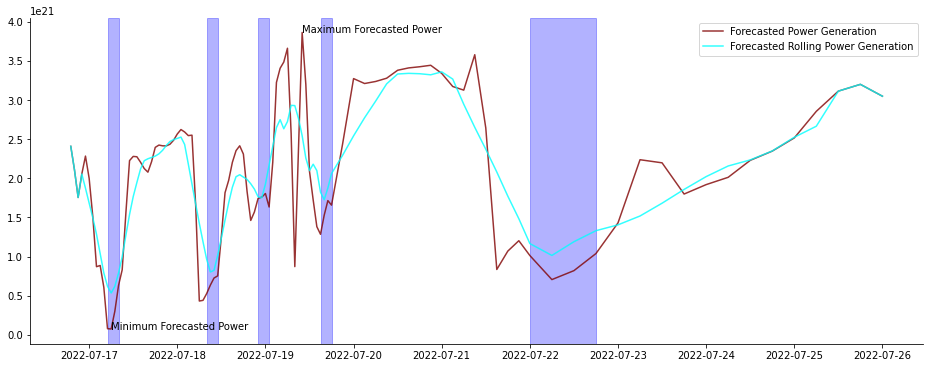

In [145]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

forecastPlot=forecast.iloc[2:]
forecastPlot['index']=range(len(forecastPlot))
forecastPlot.index=range(len(forecastPlot))
forecastPlot.set_index('index')

forecastPlot= forecastPlot.reindex()


forecastPlot['predictedGeneration'] = forecastPred

fig, ax = plt.subplots(figsize=(2, 2))

plt.plot(forecastPlot['date'],forecastPred,color = 'maroon',label = 'Forecasted Power Generation', alpha = 0.8)
plt.plot(forecastPlot['date'],forecastRoll,color = 'cyan',label = 'Forecasted Rolling Power Generation', alpha = 0.7)
forcastLen=len(forecastPlot['date'])
# highlight a time range

plt.legend(bbox_to_anchor=(1, 1))


# Removing spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


#Showing the maxima minima
plt.annotate("Maximum Forecasted Power", (forecastPlot.date[(forecastpd == max(forecastpd))].values[0], forecastpd[(forecastpd == max(forecastpd))].values[0]))
plt.annotate("Minimum Forecasted Power", (forecastPlot.date[(forecastpd == min(forecastpd))].values[0], forecastpd[(forecastpd == min(forecastpd))].values[0]))


#ax.axvspan(forecastPlot['date'][0],forecastPlot['date'][2], color="blue", alpha=0.3)
i=0
j=0
while i < forcastLen:
    print("Itererating with I and J",i,j)
    j = 0

    while ((i+j) <= forcastLen) and ( highlights[i]):
        if (i+j != forcastLen) and (highlights[i+j]):
            j=j+1
        elif(i+j != forcastLen):
            print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][j+i+1], color="blue", alpha=0.3)
            i = i+j
        else:
            print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][i], color="blue", alpha=0.3)
            i = i+j
    i=i+1
        
forecastPlot['rawTemp']=rawTemp
forecastPlot.to_csv(path_or_buf='./dashboard/chargeTimeDashboard/forecastPlot.csv',index=False)

#plt.legend(bbox_to_anchor=(0.89, 0.98))
plt.legend(loc=1)

fig = plt.gcf()
fig.set_size_inches(16, 6)
fig.savefig('./dashboard/chargeTimeDashboard/forecast.png', dpi=100)


/tmp/ipykernel_478551/2825828548.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecastPlot['index']=range(len(forecastPlot))


Itererating with I and J 0 0
Itererating with I and J 1 0
Itererating with I and J 2 0
Itererating with I and J 3 0
Itererating with I and J 4 0
Itererating with I and J 5 0
Itererating with I and J 6 0
Itererating with I and J 7 0
Itererating with I and J 8 0
Itererating with I and J 9 0
Itererating with I and J 10 0
Itererating with I and J 11 0
Plotting with i and j are given by 11 1 And the date-time being 2022-07-17 06:00:00+00:00
Itererating with I and J 13 1
Itererating with I and J 14 0
Itererating with I and J 15 0
Itererating with I and J 16 0
Itererating with I and J 17 0
Itererating with I and J 18 0
Itererating with I and J 19 0
Itererating with I and J 20 0
Itererating with I and J 21 0
Itererating with I and J 22 0
Itererating with I and J 23 0
Itererating with I and J 24 0
Itererating with I and J 25 0
Itererating with I and J 26 0
Itererating with I and J 27 0
Itererating with I and J 28 0
Itererating with I and J 29 0
Itererating with I and J 30 0
Itererating with I a

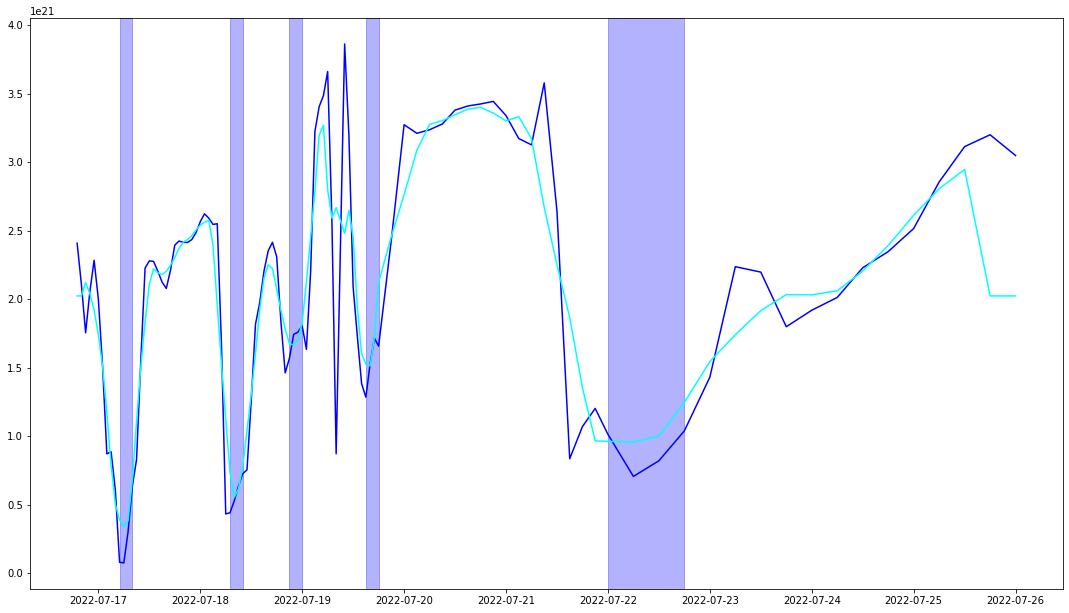

In [23]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

forecastPlot=forecast.iloc[2:]
forecastPlot['index']=range(len(forecastPlot))
forecastPlot.index=range(len(forecastPlot))
forecastPlot.set_index('index')

forecastPlot= forecastPlot.reindex()


forecastPlot['predictedGeneration'] = forecastPred

fig, ax = plt.subplots(figsize=(4, 4))

plt.plot(forecastPlot['date'],forecastPred,color = 'blue')
plt.plot(forecastPlot['date'],forecastRoll,color = 'cyan')
forcastLen=len(forecastPlot['date'])
# highlight a time range

#ax.axvspan(forecastPlot['date'][0],forecastPlot['date'][2], color="blue", alpha=0.3)
i=0
j=0
while i < forcastLen:
    print("Itererating with I and J",i,j)
    j = 0

    while ((i+j) <= forcastLen) and ( highlights[i]):
        if (i+j != forcastLen) and (highlights[i+j]):
            j=j+1
        elif(i+j != forcastLen):
            print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][j+i+1], color="blue", alpha=0.3)
            i = i+j
        else:
            print("Plotting with i and j are given by",i,j,"And the date-time being",forecastPlot['date'][i])
            ax.axvspan(forecastPlot['date'][i-1],forecastPlot['date'][i], color="blue", alpha=0.3)
            i = i+j
    i=i+1
        
forecastPlot['rawTemp']=rawTemp
forecastPlot.to_csv(path_or_buf='./dashboard/chargeTimeDashboard/forecastPlot.csv',index=False)


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('forecast.png', dpi=100)


In [22]:

= pd.read_csv('forecastPlot.csv', parse_dates=['date'])

SyntaxError: invalid syntax (3501771968.py, line 1)

In [ ]:
forecastPlot

In [ ]:
import plost

plost.time_hist(
    data=forecastPlot,
    date='date',
    x_unit='hour',
    y_unit='day',
    color='predictedGeneration',
    aggregate='median',
    legend=None)


In [ ]:
forecast=forecast.drop('date',1)
forecast=forecast.drop('dayInMonth',1)
forecast=forecast.drop('hour',1)
forecast=forecast.drop('dayOfWeek',1)
forecast=forecast.drop('dayOfYear',1)

In [ ]:
len(forecast.columns)

In [ ]:
tf_forecast=tf.convert_to_tensor(forecast)

In [ ]:
conv_model.predict(tf_forecast)

In [ ]:
[print(i.shape, i.dtype, i.name) for i in conv_model.inputs]
